In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# ฟังก์ชันตรวจจับ Drip
def detect_drip(data, window=12, threshold=-0.05):
  drips = []
  for i in range(len(data) - window):
    # เพิ่มในฟังก์ชัน detect_drip
    if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
      continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+window].min()
    drip_pct = (low_price - close_price) / close_price
    if drip_pct <= threshold:
      drips.append({
        'start_time': data.index[i],
        'close_price': close_price,
        'low_price': low_price,
        'drip_pct': drip_pct * 100,  # แปลงเป็น %
        'window_end_time': data.index[i+window-1]
      })
  
  return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
drips = detect_drip(data, window=12, threshold=-0.05)

In [4]:
# เพิ่มคอลัมน์เดือน (1=มกราคม, 12=ธันวาคม)
drips['month'] = drips['start_time'].dt.month

# 1. ค่าเฉลี่ยของขนาด Drip ในแต่ละเดือน
monthly_means = drips.groupby('month')['drip_pct'].mean().reset_index()
monthly_means.columns = ['Month', 'Mean Drip Size (%)']
print("\nMean Drip Size by Month:")
print(monthly_means.round(2))


Mean Drip Size by Month:
    Month  Mean Drip Size (%)
0       1               -7.13
1       2               -6.66
2       3               -6.69
3       4               -6.08
4       5               -6.92
5       6               -6.18
6       7               -5.70
7       8               -6.33
8       9               -7.09
9      10               -5.79
10     11               -6.98
11     12               -7.52


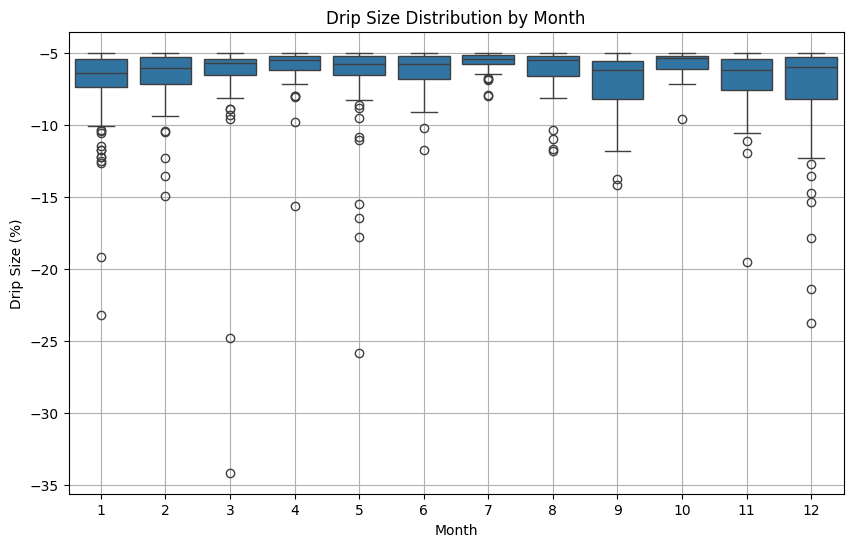

In [5]:
# สร้าง Boxplot เพื่อแสดงการกระจายของขนาด Drip ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='drip_pct', data=drips)
plt.title('Drip Size Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Drip Size (%)')
plt.grid(True)
plt.show()

In [6]:
# 2. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ยระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['drip_pct'] for month in drips['month'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("There is a significant difference in mean Drip sizes between months (p < 0.05)")
    else:
        print("No significant difference in mean Drip sizes between months (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough months to perform the test.")


One-Way ANOVA Test: F=2.2712, p-value=0.0101
There is a significant difference in mean Drip sizes between months (p < 0.05)


In [7]:
# 3. T-Test: เปรียบเทียบค่าเฉลี่ยระหว่างคู่เดือน
print("\nT-Test Results (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['drip_pct']
    group2 = drips[drips['month'] == month2]['drip_pct']
    if len(group1) > 1 and len(group2) > 1:  # ต้องมีข้อมูลเพียงพอ
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9       1.8020   0.0749
1     8 vs 10      -1.3692   0.1757
2     8 vs 11       1.5049   0.1355
3     8 vs 12       1.9754   0.0505
4      8 vs 1       1.6780   0.0957
..        ...          ...      ...
61     4 vs 6       0.3561   0.7225
62     4 vs 7      -1.1494   0.2539
63     5 vs 6      -1.5861   0.1152
64     5 vs 7      -1.9882   0.0496
65     6 vs 7      -1.9059   0.0597

[66 rows x 3 columns]


In [8]:
# 4. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ยระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['drip_pct'], groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")


Tukey’s HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4734 0.9949 -0.9449 1.8916  False
     1      3   0.4399 0.9961 -0.9219 1.8017  False
     1      4   1.0558 0.5671 -0.5347 2.6462  False
     1      5   0.2115    1.0 -1.2004 1.6235  False
     1      6    0.951 0.5732 -0.4871 2.3891  False
     1      7   1.4302 0.2701 -0.3595   3.22  False
     1      8   0.8084 0.9082 -0.8463 2.4631  False
     1      9   0.0423    1.0 -1.4945 1.5792  False
     1     10   1.3496  0.534 -0.6419 3.3411  False
     1     11   0.1554    1.0 -1.2827 1.5935  False
     1     12  -0.3835 0.9986 -1.7129 0.9459  False
     2      3  -0.0335    1.0 -1.5258 1.4588  False
     2      4   0.5824 0.9937 -1.1211  2.286  False
     2      5  -0.2618    1.0    -1.8 1.2764  False
     2      6   0.4776 0.9976 -1.0846 2.0399  False
     2      7   0.9569 0.8858 -0.9341

In [9]:
# 5. F-Test: เปรียบเทียบความแปรปรวนระหว่างคู่เดือน
print("\nF-Test Results (p-values for pairwise variance comparisons):")
f_test_results = []
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['drip_pct']
    group2 = drips[drips['month'] == month2]['drip_pct']
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results (p-values for pairwise variance comparisons):
   Month Pair  F-Statistic  P-Value
0      8 vs 9       1.4357   0.1122
1     8 vs 10       3.4547   0.0010
2     8 vs 11       1.6811   0.0324
3     8 vs 12       4.0071   0.0000
4      8 vs 1       2.4442   0.0002
..        ...          ...      ...
61     4 vs 6       1.7357   0.0221
62     4 vs 7       4.9601   0.0000
63     5 vs 6       6.8459   0.0000
64     5 vs 7      19.5639   0.0000
65     6 vs 7       2.8578   0.0009

[66 rows x 3 columns]


In [10]:
# 6. Levene’s Test: เปรียบเทียบความแปรปรวนระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['drip_pct'] for month in drips['month'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough months to perform the test.")


Levene’s Test for Variance: stat=1.9244, p-value=0.0335
Variances are significantly different (p < 0.05)


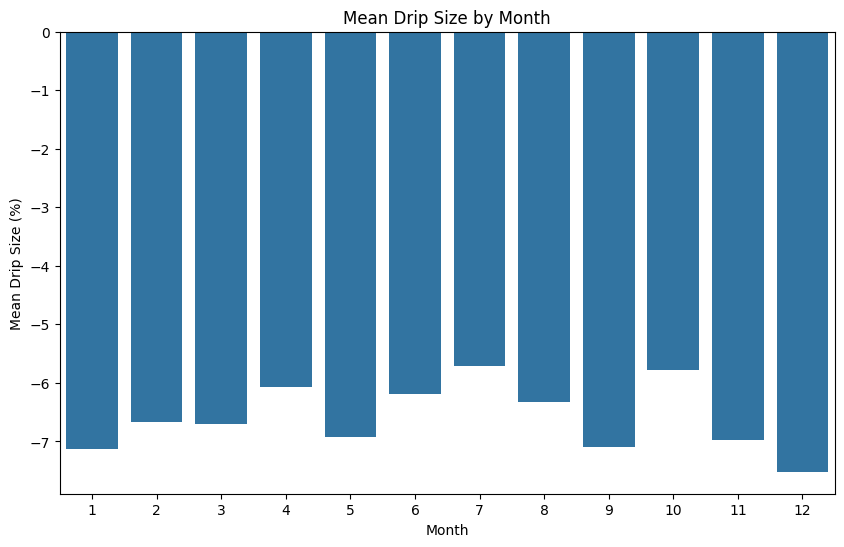

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Mean Drip Size (%)', data=monthly_means)
plt.title('Mean Drip Size by Month')
plt.show()